# A comet from TESS Beta Pictoris with TLS
We will use TLS to recover an exocomet found in the Beta Pictoris
light curves from TESS. We will download the curves thanks to the
`lightkurve` package. Then, we will execute TLS with the known
stellar parameters from TESS ExoFOP.

In [9]:
import matplotlib.pyplot as plt; plt.rcParams["figure.dpi"] = 150
import lightkurve as lk
import transitleastsquares as tls
import numpy

lcf = lk.search_lightcurvefile("TIC 270577175", mission="TESS", cadence="short").download_all()
power_args = {'transit_template': 'comet', 'period_min': 1, 'period_max': 33, 'u': (0.25, 0.64), 'R_star': 1.54, 'R_star_min': 1.1400000000000001, 'R_star_max': 1.94, 'M_star': 1.95, 'M_star_min': 1.5499999999999998, 'M_star_max': 2.35}
pdcsap_flux = lcf.PDCSAP_FLUX.stitch().remove_nans()
args = numpy.where(pdcsap_flux.time > 1440)
pdcsap_flux.flux = pdcsap_flux.flux[args]
pdcsap_flux.time = pdcsap_flux.time[args]
model = tls.transitleastsquares(pdcsap_flux.time, pdcsap_flux.flux)
results = model.power(**power_args)

/home/martin/git_repositories/transitleastsquares/transitleastsquares/transit_template_generator.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lc_arr = numpy.array(lc_arr)
100%|██████████| 5056/5056 periods | 06:17<00:00


Transit Least Squares TLS 1.0.25 (04 June 2020)
Creating model cache for 66 durations
Searching 47627 data points, 5056 periods from 1.0 to 32.986 days
Using all 8 CPU threads


Let's see the periodiogram:

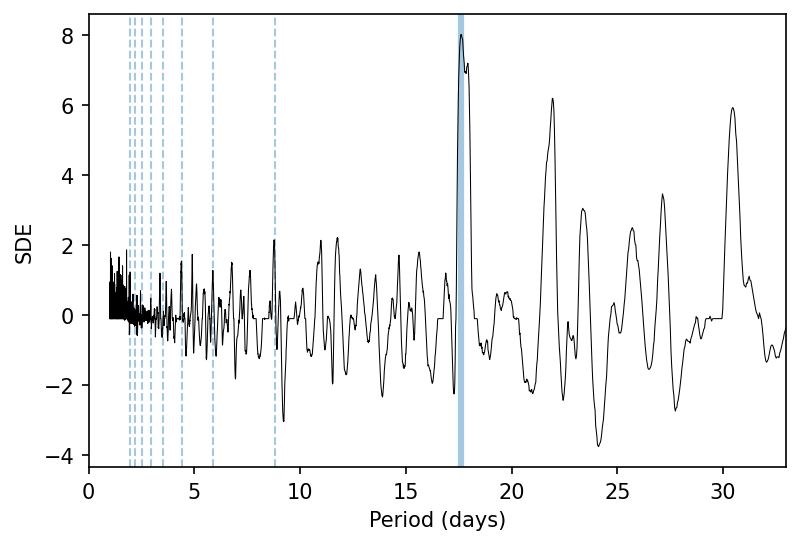

In [10]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(numpy.min(results.periods), numpy.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods));

That's a strong signal. Let's look at the phase fold:

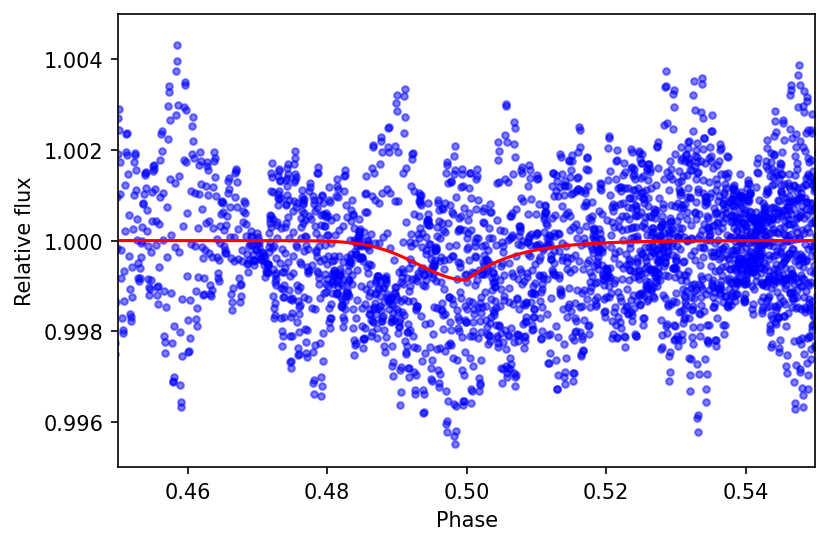

In [16]:
plt.figure()
plt.plot(results.model_folded_phase, results.model_folded_model, color='red')
plt.scatter(results.folded_phase, results.folded_y, color='blue', s=10, alpha=0.5, zorder=2)
plt.xlim(0.45, 0.55)
plt.ylim(0.995, 1.005)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

We can see that the fit is far to be perfect. This is
because the comet that we found was not really periodic, as mentioned in the
original article from Zieba et al. (2019), and the other matched transits are only
noise.

In the next plot we can inspect the entire light curve, where we can
see the matched exocomet at BJD=1486.

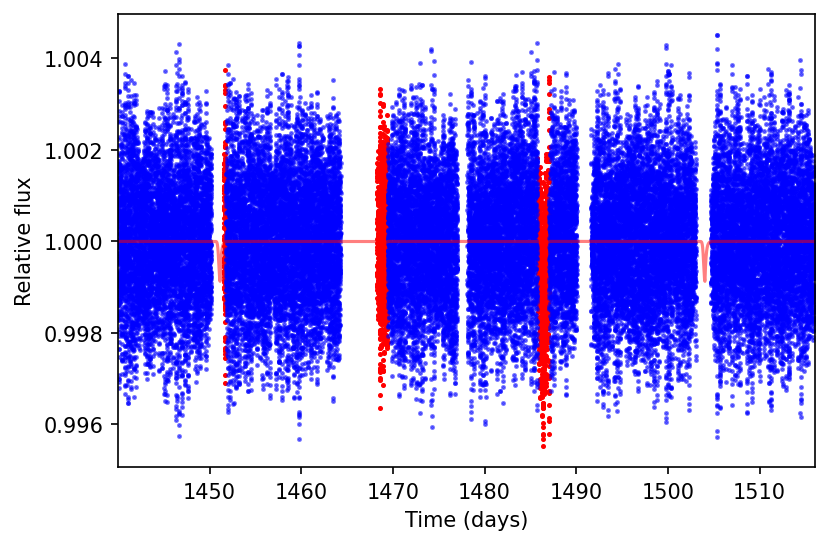

In [12]:
plt.figure()
in_transit = tls.transit_mask(pdcsap_flux.time, results.period, results.duration, results.T0)
plt.scatter(pdcsap_flux.time[in_transit], pdcsap_flux.flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(pdcsap_flux.time[~in_transit], pdcsap_flux.flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color='red', zorder=1)
plt.xlim(pdcsap_flux.time.min(), pdcsap_flux.time.max())
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');

If we focus the light curve into the exocomet transit:

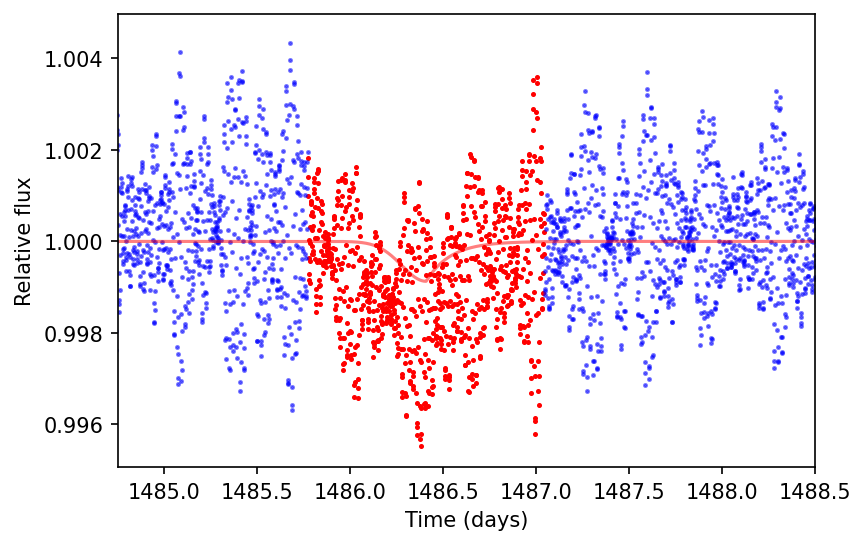

In [20]:
plt.figure()
in_transit = tls.transit_mask(pdcsap_flux.time, results.period, results.duration, results.T0)
plt.scatter(pdcsap_flux.time[in_transit], pdcsap_flux.flux[in_transit], color='red', s=2, zorder=0)
plt.scatter(pdcsap_flux.time[~in_transit], pdcsap_flux.flux[~in_transit], color='blue', alpha=0.5, s=2, zorder=0)
plt.plot(results.model_lightcurve_time, results.model_lightcurve_model, alpha=0.5, color='red', zorder=1)
plt.xlim(1484.75, 1488.5)
plt.xlabel('Time (days)')
plt.ylabel('Relative flux');

We conclude that TLS was able to spot the exocomet and assign it a period.
This is not a perfect example but it is a good showcase to show the TLS
capabilities to spot exocomets and also evaporating planets, whose transit
shapes are very similar.